In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint ,  solve_ivp
import datetime
import matplotlib.ticker as plticker

from sys import platform

if platform == "darwin":
    folder="/Users/sjha/Documents/Github/new_model_data/"  ## mac
if platform == "win32":
    folder="C:\\Users\\jhash\\Documents\\renders\\opto\\" ## windows

print(folder)


C:\Users\jhash\Documents\renders\opto\


In [22]:
g_y=1.24e6   ##Hz
omega_0=4.45e15 ##Hz
del_omega=1e8
omega_1=omega_0-del_omega ##Hz
ohm=1e6         ##Hz
g_z0=0
g_z1=(20*ohm)**0.5
delta_0=100*ohm
N0=1e1

g_y/=ohm
g_z1/=ohm
g_z0/=ohm
omega_1/=ohm
omega_0/=ohm
del_omega/=ohm

# label_list=["$Q$","$P$","$1-n_0$","$n_1$","$n_{-1}$","$\sigma_-$","E_mech"]


In [28]:
def evol_mat(delta,g,N0,q0):
    M=np.array([
        [0,1,0,0,0,0],
        [-1,0,0,2*g*N0,0,0],
        [-g,0,0,-delta,-g*q0,0],
        [0,0,delta,0,0,-g*q0],
        [0,0,g*q0/2,0,0,0],
        [0,0,0,g*q0/2,0,0],
    ])
    return M

def real_ODE(t,z,g_z1,g_y,del_omega,N0):
    q_z,p_z,q_y,p_y,A0_p,A0_m,A1_p,A1_m,E_opt_0,E_opt_1,E_mech_z,E_mech_y,E_c=z

    sigma_m=2*(A1_p*A0_m-A1_m*(A0_p+1))
    q_y_dot=p_y
    p_y_dot=-q_y-g_y*N0*sigma_m
    q_z_dot=p_z
#     p_z_dot=-q_z-g_z1*N0*(A1_p**2+A1_m**2)
    p_z_dot=-q_z+2*g_z1*N0*(2*A0_p+A0_p**2+A0_m**2)
    A1_p_dot=-(del_omega-g_z1*q_z)*A1_m-g_y*q_y*(1+A0_p)
    A1_m_dot=+(del_omega-g_z1*q_z)*A1_p-g_y*q_y*A0_m
    A0_p_dot=g_y*q_y*A1_p/2
    A0_m_dot=g_y*q_y*A1_m/2
    
    E_c_dot=2*N0*(A0_p_dot*(A0_p+1)+A0_m_dot*A0_m)*(-g_z1*q_z)+g_y*q_y*N0*(A1_p_dot*A0_m+A1_p*A0_m_dot-A1_m_dot*(A0_p+1)-A1_m*A0_p_dot)-N0*g_z1*(2*A0_p+A0_p**2+A0_m**2)*q_z_dot+g_y*q_y_dot*N0*(A1_p*A0_m-A1_m*(A0_p+1))
    E_mech_dot=(q_y*q_y_dot+p_y*p_y_dot+q_z*q_z_dot+p_z*p_z_dot)/2
    E_mech_z_dot=(q_z*q_z_dot+p_z*p_z_dot)/2
    E_mech_y_dot=(q_y*q_y_dot+p_y*p_y_dot)/2
    E_opt_0_dot=2*N0*(A0_p_dot*(A0_p+1)+A0_m_dot*A0_m)*omega_0
    E_opt_1_dot=N0*(A1_p_dot*A1_p+A1_m_dot*A1_m)*omega_1
    x_list=[q_z_dot,p_z_dot,q_y_dot,p_y_dot,A0_p_dot,A0_m_dot,A1_p_dot,A1_m_dot,E_opt_0_dot,E_opt_1_dot,E_mech_z_dot,E_mech_y_dot,E_c_dot]
    return x_list

def real_ODE2(t,z,g_z1,g_y,del_omega,N0):
    q_z,p_z,q_y,p_y,A0_p,A0_m,A1_p,A1_m,E_opt_0,E_opt_1,E_mech_z,E_mech_y,E_c=z

    sigma_m=-2*A1_m
    q_y_dot=p_y
    p_y_dot=-q_y-g_y*N0*sigma_m
    q_z_dot=p_z
#     p_z_dot=-q_z-g_z1*N0*(A1_p**2+A1_m**2)
    p_z_dot=-q_z+2*g_z1*N0*(2*A0_p+A0_p**2+A0_m**2)
    A1_p_dot=-(del_omega-g_z1*q_z)*A1_m-g_y*q_y*(1+A0_p)
    A1_m_dot=+(del_omega-g_z1*q_z)*A1_p-g_y*q_y*A0_m
    A0_p_dot=g_y*q_y*A1_p/2
    A0_m_dot=g_y*q_y*A1_m/2
    
    E_c_dot=2*N0*(A0_p_dot*(A0_p+1)+A0_m_dot*A0_m)*(-g_z1*q_z)+g_y*q_y*N0*(A1_p_dot*A0_m+A1_p*A0_m_dot-A1_m_dot*(A0_p+1)-A1_m*A0_p_dot)-N0*g_z1*(2*A0_p+A0_p**2+A0_m**2)*q_z_dot+g_y*q_y_dot*N0*(A1_p*A0_m-A1_m*(A0_p+1))
    E_mech_dot=(q_y*q_y_dot+p_y*p_y_dot+q_z*q_z_dot+p_z*p_z_dot)/2
    E_mech_z_dot=(q_z*q_z_dot+p_z*p_z_dot)/2
    E_mech_y_dot=(q_y*q_y_dot+p_y*p_y_dot)/2
    E_opt_0_dot=2*N0*(A0_p_dot*(A0_p+1)+A0_m_dot*A0_m)*omega_0
    E_opt_1_dot=N0*(A1_p_dot*A1_p+A1_m_dot*A1_m)*omega_1
    x_list=[q_z_dot,p_z_dot,q_y_dot,p_y_dot,A0_p_dot,A0_m_dot,A1_p_dot,A1_m_dot,E_opt_0_dot,E_opt_1_dot,E_mech_z_dot,E_mech_y_dot,E_c_dot]
    return x_list

    
def real_evolve(z0,tf,param_list,N_step=300,method="DOP853",f=real_ODE):
    t = np.linspace(0,tf,N_step)
    xx=solve_ivp(f, [0,tf],z0,args=param_list,dense_output=False,rtol = 1e-8, atol = 1e-10, t_eval=t,method=method)
    zz=xx.y
    sol=[]
#     for i in range(np.shape(zz)[0]):
#         sol.append(np.real(zz[i]))
    for i in [2,3,7]:
        sol.append(np.real(zz[i]))
    return sol,t

def reduced_ODE(t,z,g_z1,g_y,del_omega,N0):
    q_y,p_y,Am,Am_d=z
    q_y_dot=p_y
    p_y_dot=-q_y+2*g_y*N0*Am
    Am_dot=Am_d
    Am_d_dot=-del_omega**2*Am-del_omega*g_y*q_y-(g_y*q_y)**2*Am/2
    x_list=[q_y_dot,p_y_dot,Am_dot,Am_d_dot]
    return x_list

def reduced_evolve(z0,tf,param_list,N_step=300,method="DOP853"):
    t = np.linspace(0,tf,N_step)
    xx=solve_ivp(reduced_ODE, [0,tf],z0,args=param_list,dense_output=False,rtol = 1e-8, atol = 1e-10, t_eval=t,method=method)
    zz=xx.y
    sol=[]
    for i in [0,1,2]:
        sol.append(np.real(zz[i]))
    return sol,t


N0= 12500.0


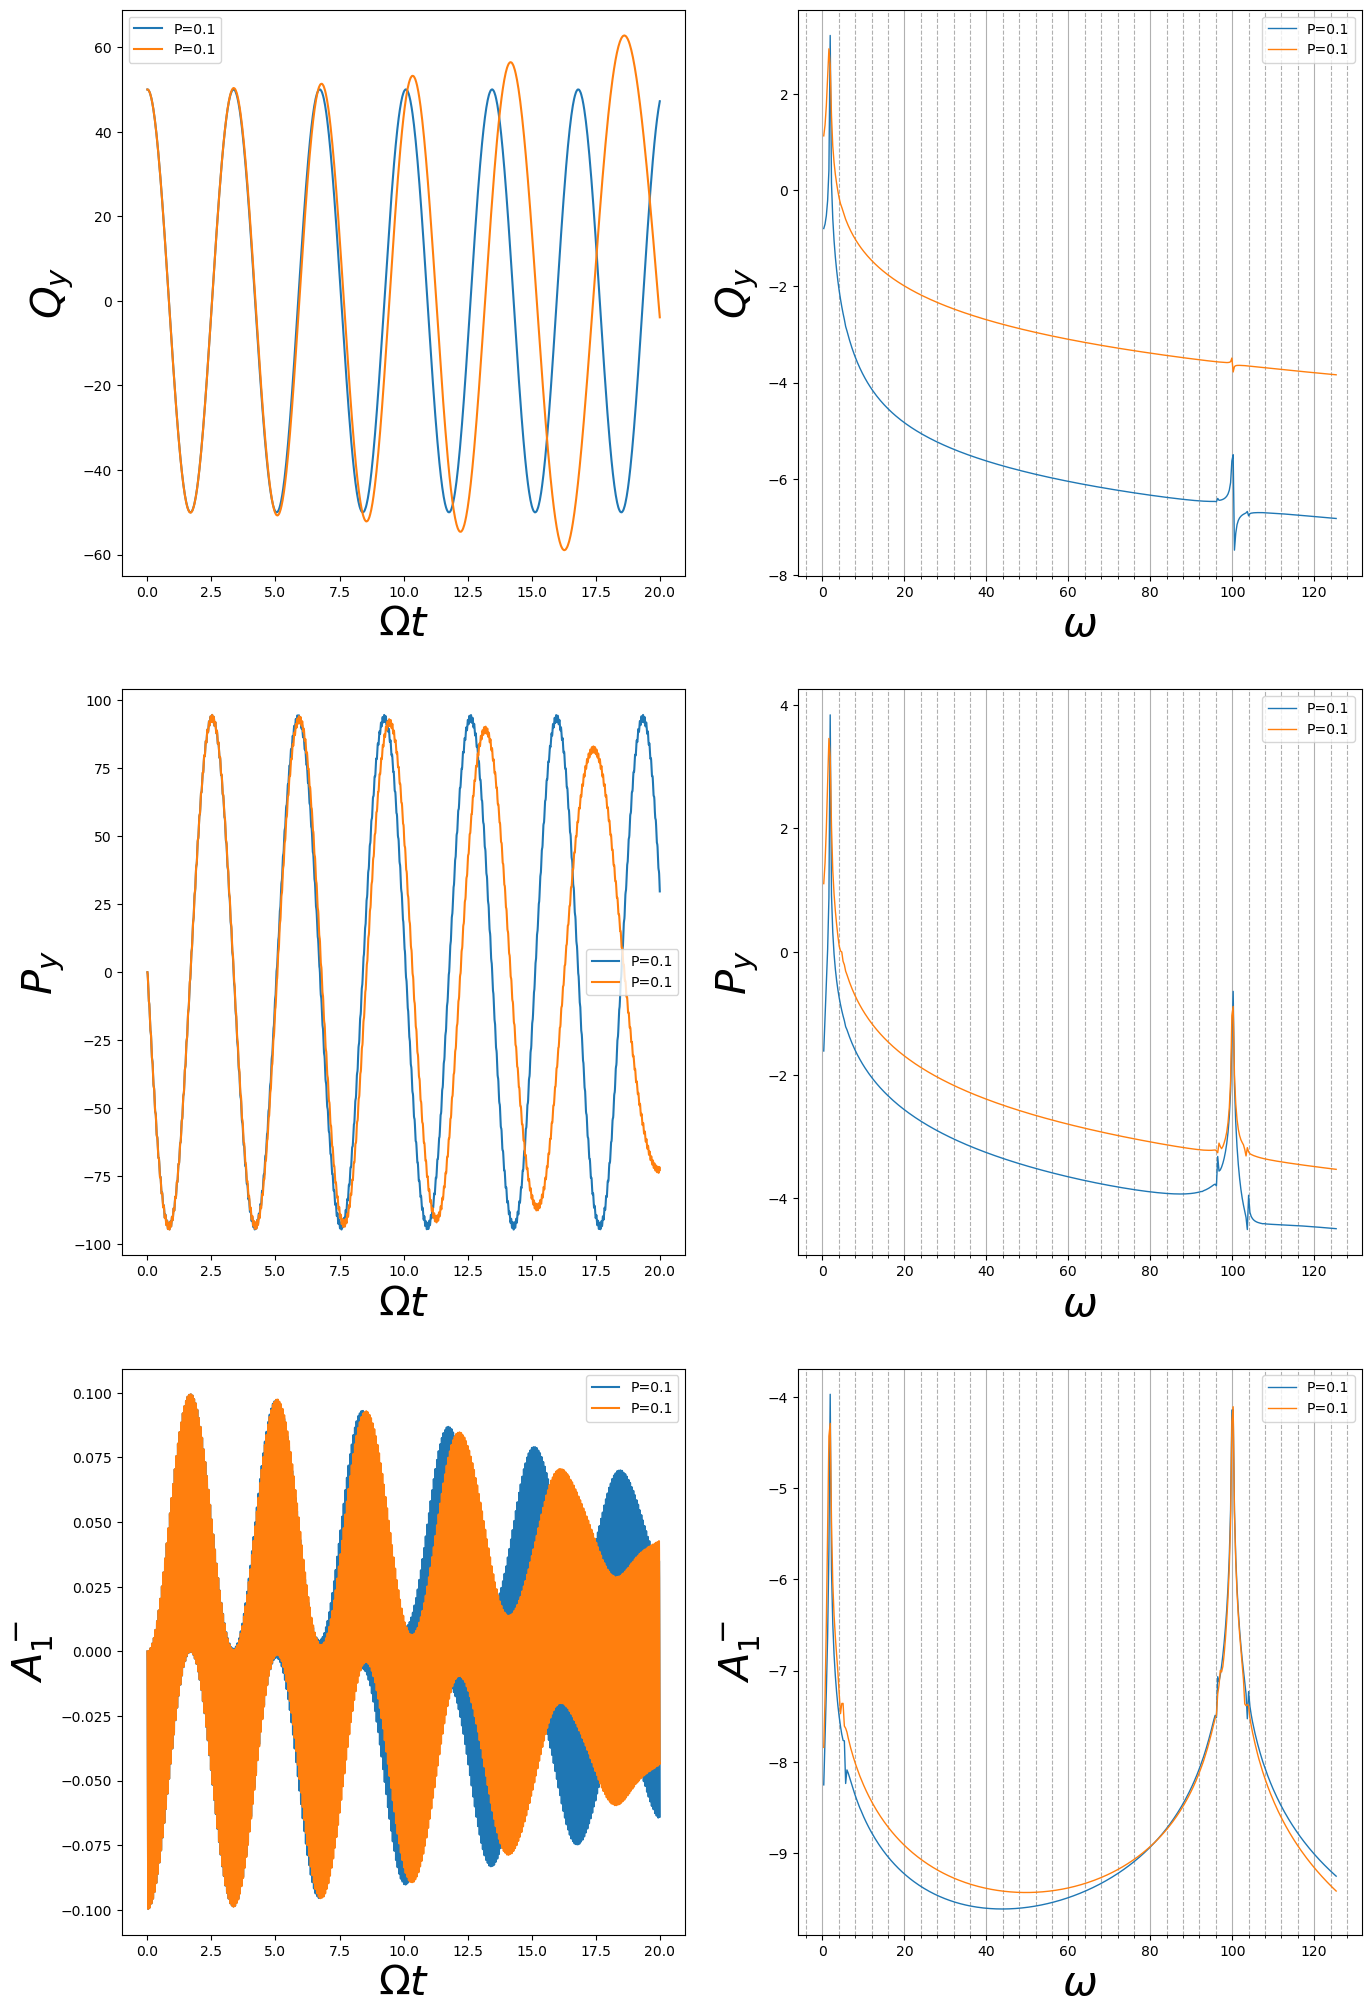

In [36]:
g_z1=0############ 
P_list=np.array([0.1]) ############### CRITICAL parameter
g_y=1e-1
print("N0=",np.round(N0))

label_list=["$Q_y$","$P_y$","$A_1^-$"]
# label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$","$H$","$N$"]

tf=2e1
N_step=10000
qy_0=50
z_0=np.array([0,0,qy_0,0,0,0,0,0, N0*del_omega,0,0, qy_0**2/4,0],dtype=complex)  ### 0 mode excitation
sf,ef=1,400
om=2*np.pi*np.arange(N_step//2+1)[sf:ef]/tf

i=7
fig, axs = plt.subplots(3, 2,figsize=(16,25))
# i_list=[2,3,7]
for P in (P_list):
    N0=(P*del_omega)**3/(8*g_y**2)
    param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    
    z_0=np.array([0,0,qy_0,0,0,0,0,0, N0*del_omega,0,0, qy_0**2/4,0],dtype=complex)  ### 0 mode excitation
    zz1,t=real_evolve(z_0,tf,param_list,N_step,f=real_ODE)
    zz2,t=real_evolve(z_0,tf,param_list,N_step,f=real_ODE2)

    for i in range(3):
        axs[i,0].plot(t,zz1[i],label="P={0}".format(P))
        axs[i,0].plot(t,zz2[i],label="P={0}".format(P))
        zff1=np.log(np.abs(np.fft.rfft(zz1[i]))/N_step)
        zff2=np.log(np.abs(np.fft.rfft(zz2[i]))/N_step)
#         zff=(np.abs(np.fft.rfft(zz[i]))/N_step)
        axs[i,1].plot(om,zff1[sf:ef],label="P={0}".format(P),linewidth=1)
        axs[i,1].plot(om,zff2[sf:ef],label="P={0}".format(P),linewidth=1)

for i in range(3):
    axs[i,0].set_ylabel(label_list[i],fontsize=30)
    axs[i,0].set_xlabel('$\Omega t$',fontsize=30)
    axs[i,0].legend()

    axs[i,1].set_ylabel(label_list[i],fontsize=30)
    axs[i,1].set_xlabel('$\omega$',fontsize=30)
    axs[i,1].legend()
    axs[i,1].xaxis.set_major_locator(plticker.MultipleLocator(20))
    axs[i,1].xaxis.set_minor_locator(plticker.MultipleLocator(4))
    axs[i,1].grid(axis = 'x',which="major")
    axs[i,1].grid(axis = 'x',which="minor", linestyle='--')
    #     axs[i//2,i%2].legend(fontsize=12)

plt.show() 

N0= 12500.0


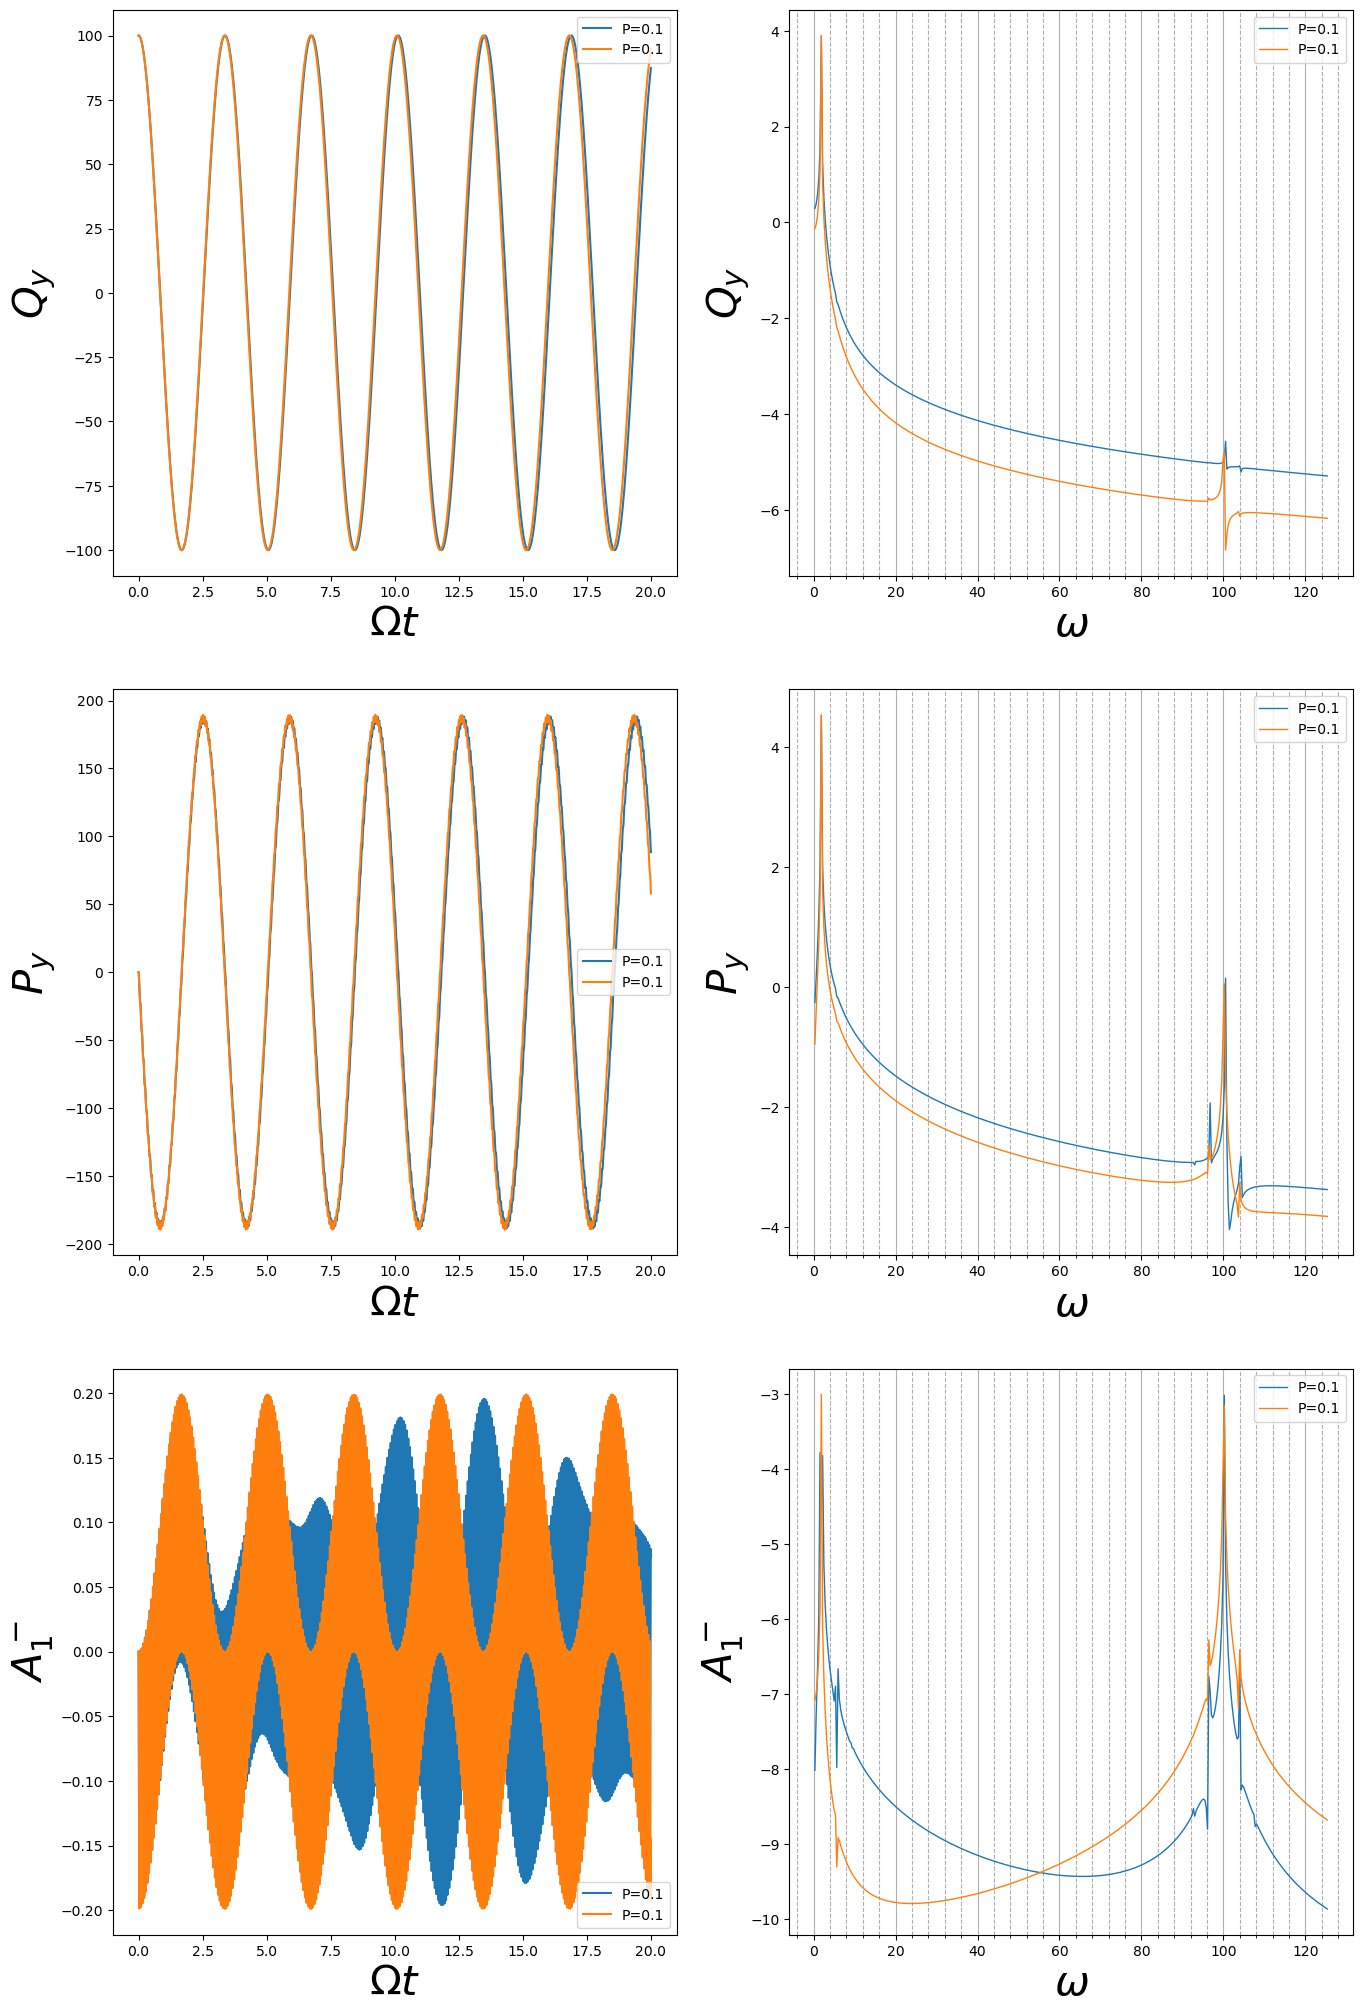

In [37]:
g_z1=0############ 
P_list=np.array([0.1]) ############### CRITICAL parameter
g_y=1e-1
print("N0=",np.round(N0))

label_list=["$Q_y$","$P_y$","$A_1^-$"]
# label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$","$H$","$N$"]

tf=2e1
N_step=10000
qy_0=100
z_0=np.array([0,0,qy_0,0,0,0,0,0, N0*del_omega,0,0, qy_0**2/4,0],dtype=complex)  ### 0 mode excitation
sf,ef=1,400
om=2*np.pi*np.arange(N_step//2+1)[sf:ef]/tf

i=7
fig, axs = plt.subplots(3, 2,figsize=(16,25))
# i_list=[2,3,7]
for P in (P_list):
    N0=(P*del_omega)**3/(8*g_y**2)
    param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    
    z_0=np.array([0,0,qy_0,0,0,0,0,0, N0*del_omega,0,0, qy_0**2/4,0],dtype=complex)  ### 0 mode excitation
    zz_real,t=real_evolve(z_0,tf,param_list,N_step)
    z_0=np.array([qy_0,0,0,0],dtype=complex)  ### 0 mode excitation
    zz_red,t=reduced_evolve(z_0,tf,param_list,N_step)

    for i in range(3):
        axs[i,0].plot(t,zz_real[i],label="P={0}".format(P))
        axs[i,0].plot(t,zz_red[i],label="P={0}".format(P))
        zff_real=np.log(np.abs(np.fft.rfft(zz_real[i]))/N_step)
        zff_red=np.log(np.abs(np.fft.rfft(zz_red[i]))/N_step)
#         zff=(np.abs(np.fft.rfft(zz[i]))/N_step)
        axs[i,1].plot(om,zff_real[sf:ef],label="P={0}".format(P),linewidth=1)
        axs[i,1].plot(om,zff_red[sf:ef],label="P={0}".format(P),linewidth=1)

for i in range(3):
    axs[i,0].set_ylabel(label_list[i],fontsize=30)
    axs[i,0].set_xlabel('$\Omega t$',fontsize=30)
    axs[i,0].legend()

    axs[i,1].set_ylabel(label_list[i],fontsize=30)
    axs[i,1].set_xlabel('$\omega$',fontsize=30)
    axs[i,1].legend()
    axs[i,1].xaxis.set_major_locator(plticker.MultipleLocator(20))
    axs[i,1].xaxis.set_minor_locator(plticker.MultipleLocator(4))
    axs[i,1].grid(axis = 'x',which="major")
    axs[i,1].grid(axis = 'x',which="minor", linestyle='--')
    #     axs[i//2,i%2].legend(fontsize=12)

plt.show() 

In [35]:
N_grid=100
qy_0_list=(np.linspace(1/N_grid,1,N_grid,endpoint=True)*2e2).astype(int)
P_list=np.round(np.linspace(1/N_grid,1,N_grid,endpoint=True),2)
lam=np.zeros((N_grid,N_grid,6),dtype=complex)

for i,P in enumerate(P_list):
    N0=(P*del_omega)**3/(8*g_y**2)
    for j,qy_0 in enumerate(qy_0_list):
        E=np.linalg.eigvals(evol_mat(del_omega,g_y,N0,qy_0))
        for k in range(6):
            lam[i,j,k]=E[k]

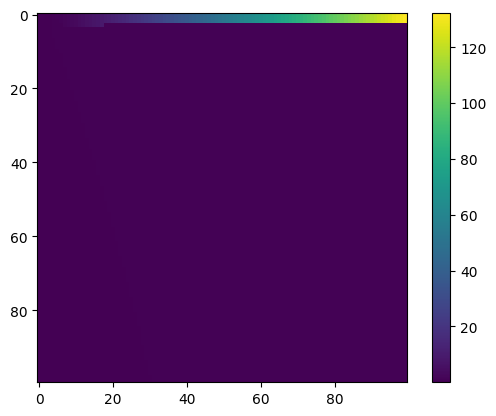

In [38]:
plt.imshow(np.imag(lam[:,:,4]))
plt.colorbar()

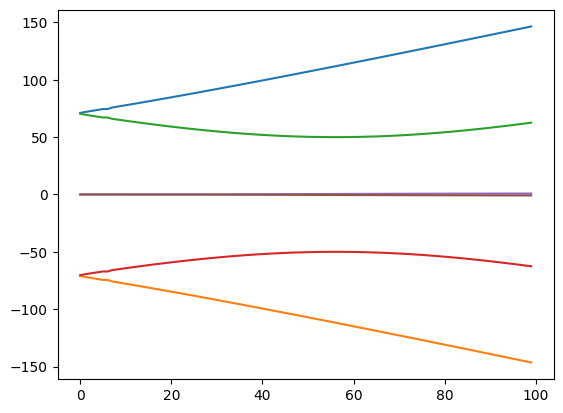

In [49]:
N_grid=100
qy_0_list=(np.linspace(1/N_grid,1,N_grid,endpoint=True)*1e2).astype(int)
P=1
lam=np.zeros((N_grid,6),dtype=complex)

N0=(P*del_omega)**3/(8*g_y**2)
for j,qy_0 in enumerate(qy_0_list):
    E=np.linalg.eigvals(evol_mat(del_omega,g_y,N0,qy_0))
    for k in range(6):
        lam[j,k]=E[k]
        
for i in range(6):
    plt.plot(np.imag(lam[:,i]))
    
plt.show()

In [50]:
lam[0,:]

array([ 1.39019724e-13+7.10852286e+01j,  1.39019724e-13-7.10852286e+01j,
       -1.41796100e-13+7.03521704e+01j, -1.41796100e-13-7.03521704e+01j,
       -8.41702100e-19+1.53729251e-04j, -8.41702100e-19-1.53729251e-04j])